In [17]:
using Revise
using Bilevel
using Bilevel: VariableSelector, ConstraintSelector, add_var!, add_eq!, add_ineq!, contact_jacobian!, contact_friction_τ_direct!, contact_normal_τ_direct!, contact_friction_τ_direct_osqp!

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using ForwardDiff
using Base.Threads
using BenchmarkTools
using SparseArrays

In [2]:
urdf = joinpath("..", "..", "urdf", "box2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.125)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [0.0, 0.0, -0.0375], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false))])

In [3]:
N = 10
Δt = 0.1
q0 = [0., -0.0375, 0.]
v0 = [7., 0., 0.]

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[0.0, -0.0375, 0.0], [0.589637, -0.0375, 6.82873e-6], [1.06891, -0.0375, 2.04862e-5], [1.43782, -0.0375, 4.09726e-5], [1.69636, -0.0375, 6.82878e-5], [1.84453, -0.0375, 0.000102432], [1.88234, -0.0375, 0.000143405], [1.88234, -0.0375, 0.000186718], [1.88234, -0.0375, 0.00023003], [1.88234, -0.0375, 0.000273342]], Array{Float64,1}[[7.0, 0.0, 0.0], [5.89637, -4.02647e-5, 6.82873e-5], [4.79272, -9.81849e-5, 0.000136575], [3.68907, -0.000151151, 0.000204864], [2.58542, -0.000176552, 0.000273152], [1.48175, -0.000151777, 0.000341442], [0.378072, -5.42156e-5, 0.000409732], [1.62421e-5, -3.51731e-10, 0.000433124], [1.62421e-5, -3.51748e-10, 0.000433124], [1.62421e-5, -3.51748e-10, 0.000433124]], Array{Float64,1}[], Array{Array{Float64,1},1}[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.00001, 0.0, 0.0, 1.12501, 0.0, 5.89636]], [[1.00002, 0.0, 0.0, 1.12502, 0.0, 4.79272]], [[1.00002, 0.0, 0.0, 1.12503, 0.0, 3.68907]], [[1.00003, 0.0, 0.0, 1.12503, 0.0, 2.5854]], [[1.00004, 0.0, 0.0, 

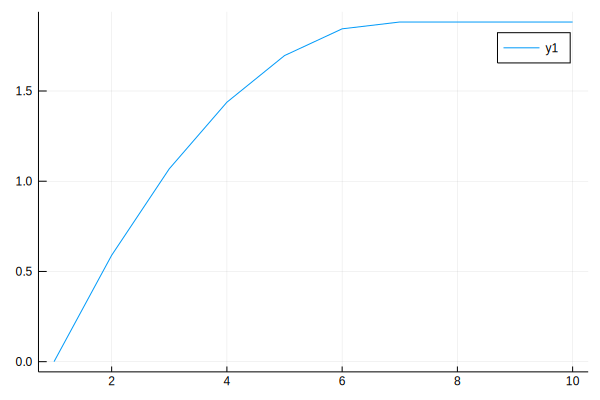

In [4]:
plot(traj[7][1,:])

In [5]:
num_pos = num_positions(mechanism)
num_vel = num_velocities(mechanism)
num_contacts = length(sim_data.env.contacts)

sample_vs = VariableSelector()
add_var!(sample_vs, :q0, num_pos)
add_var!(sample_vs, :v0, num_vel)
add_var!(sample_vs, :u0, num_vel)
add_var!(sample_vs, :qnext, num_pos)
add_var!(sample_vs, :vnext, num_vel)
add_var!(sample_vs, :h, 1)
add_var!(sample_vs, :c_n, num_contacts)

data = Array{Array{Float64,1},1}()

for n = 2:(length(traj[6])-1)
    q0 = traj[1][n]
    v0 = traj[2][n]
    u0 = zeros(num_vel)
    qnext = traj[1][n+1]
    vnext = traj[2][n+1]
    h = traj[6][n+1] - traj[6][n]
    c_n = [ traj[8][:,n][sim_data.vs(Symbol("c_n", i))][1] for i = 1:num_contacts ]
    
    sample = zeros(Float64, sample_vs.num_vars)
    sample[sample_vs(:q0)] = q0
    sample[sample_vs(:v0)] = v0
    sample[sample_vs(:u0)] = u0
    sample[sample_vs(:qnext)] = qnext
    sample[sample_vs(:vnext)] = vnext
    sample[sample_vs(:h)] = [h]
    sample[sample_vs(:c_n)] = c_n
    
    push!(data, sample)
end

In [6]:
num_samples = length(data)

sim_data = get_sim_data_direct(mechanism,env,0.01)
sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 30
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1
    
function compute_friction(;sample_range=1:num_samples)
    for i = sample_range
        sample = data[i]
        q0 = sample_vs(sample, :q0)
        v0 = sample_vs(sample, :v0)
        u0 = sample_vs(sample, :u0)
        qnext = sample_vs(sample, :qnext)
        vnext = sample_vs(sample, :vnext)
        h = sample_vs(sample, :h)[1]
        c_n = sample_vs(sample, :c_n)
        
        x0 = sim_data.state_cache[1][Float64]
        xn = sim_data.state_cache[2][Float64]
        envj = sim_data.envj_cache[2][Float64]

        set_configuration!(x0, q0)
        set_velocity!(x0, v0)
        setdirty!(x0)
        set_configuration!(xn, qnext)
        set_velocity!(xn, vnext)
        setdirty!(xn)

        normalize_configuration!(x0)
        normalize_configuration!(xn)

        H = mass_matrix(x0)
        Hi = inv(H)
        config_derivative = configuration_derivative(xn)
        dyn_bias = dynamics_bias(xn)

        contact_jacobian!(envj, xn)
        
        contact_bias = Vector{Float64}(undef, num_vel)                        
        contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
        display(contact_bias)
        
        contact_bias_osqp = Vector{Float64}(undef, num_vel)                        
        contact_friction_τ_direct_osqp!(sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
        display(contact_bias_osqp)
    end
end

compute_friction (generic function with 1 method)

In [7]:
compute_friction(sample_range=1:1)
# compute_friction()

3-element Array{Float64,1}:
  1.8210282479515243 
  1.6186251293760165 
 -0.06828731580045418

MethodError: MethodError: no method matching contact_friction_τ_direct_osqp!(::SimData, ::Float64, ::Symmetric{Float64,Array{Float64,2}}, ::EnvironmentJacobian{Float64}, ::SegmentedVector{JointID,Float64,Base.OneTo{JointID},Array{Float64,1}}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Int64)
Closest candidates are:
  contact_friction_τ_direct_osqp!(::Any, !Matched::SimData, ::Any, ::Any, !Matched::EnvironmentJacobian, ::Any, ::Any, ::Any, ::AbstractArray{U,N} where N, !Matched::AbstractArray{N,N} where N, !Matched::Int64) where {U, N} at /home/blandry/.julia/dev/Bilevel/src/contact_sim.jl:193

In [15]:
num_samples = length(data)

sim_data = get_sim_data_direct(mechanism,env,0.01)
sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 10
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1
    
sample = data[1]
q0 = sample_vs(sample, :q0)
v0 = sample_vs(sample, :v0)
u0 = sample_vs(sample, :u0)
qnext = sample_vs(sample, :qnext)
vnext = sample_vs(sample, :vnext)
h = sample_vs(sample, :h)[1]
c_n = sample_vs(sample, :c_n)
        
x0 = sim_data.state_cache[1][Float64]
xn = sim_data.state_cache[2][Float64]
envj = sim_data.envj_cache[2][Float64]

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
set_configuration!(xn, qnext)
set_velocity!(xn, vnext)
setdirty!(xn)

normalize_configuration!(x0)
normalize_configuration!(xn)

H = mass_matrix(x0)
Hi = inv(H)
config_derivative = configuration_derivative(xn)
dyn_bias = dynamics_bias(xn)

contact_jacobian!(envj, xn)
        
contact_bias = Vector{Float64}(undef, num_vel)                        
contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
display(contact_bias)
        
contact_bias_osqp = Vector{Float64}(undef, num_vel)                        
contact_friction_τ_direct_osqp!(contact_bias_osqp, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
display(contact_bias_osqp)

3-element Array{Float64,1}:
  1.8210283993979919 
  1.618625129372914  
 -0.06828732147969671

UndefVarError: UndefVarError: osqp not defined

In [20]:
Bilevel.osqp_solve

UndefVarError: UndefVarError: osqp_solve not defined

In [13]:
using OSQP
using Compat.SparseArrays

┌ Info: Precompiling OSQP [ab2f91bb-94b4-55e3-9ba0-7f65df51de79]
└ @ Base loading.jl:1186


In [14]:

# Define problem data
P = sparse([4. 1.; 1. 2.])
q = [1.; 1.]
A = sparse([1. 1.; 1. 0.; 0. 1.])
l = [1.; 0.; 0.]
u = [1.; 0.7; 0.7]

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q, A=A, l=l, u=u, alpha=1)

# Solve problem
results = OSQP.solve!(prob)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 3
          nnz(P) + nnz(A) = 7
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.00, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

iter   objective    pri res    dua res    rho        time
   1  -4.9384e-03   1.00e+00   2.00e+02   1.00e-01   4.56e-05s
  50   1.8800e+00   1.91e-07   7.50e-07   1.38e+00   3.12e-05s

status:               solved
number of iterations: 50
optimal objec

OSQP.Results([0.3, 0.7], [-2.9, 3.98447e-18, 0.2], OSQP.Info(50, :Solved, 1, 0, 1.8800000386057767, 1.9097236535375542e-7, 7.497118899024711e-7, 2.7342e-5, 6.393e-6, 1.213e-6, 0.0, 3.3735e-5, 1, 6.937973679915e-310), [NaN, NaN, NaN], [NaN, NaN])

In [43]:
results.x

2-element Array{Float64,1}:
 0.30000019111416903
 0.6999998090276346 

In [93]:
blockdiag(sparse(I, 2, 2),sparse(I, 3, 3))

5×5 SparseMatrixCSC{Bool,Int64} with 5 stored entries:
  [1, 1]  =  true
  [2, 2]  =  true
  [3, 3]  =  true
  [4, 4]  =  true
  [5, 5]  =  true